In [106]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model
from retinaface import RetinaFace
import matplotlib.image as mpimg

%matplotlib inline

In [107]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [165]:
image_dir_basepath = '../data/images/'
names = ['LarryPage',
         'MarkZuckerberg',
         'BillGates',
         'Woong',
         'Kim' ,
         'Ko',
         'Lee',
         'Seo',
         'sample1',
         'sample2',
         'sample3',
         'sample4',
         'sample5',
         'sample6',
         'sample7',
         'sample8',
         'sample9',
         'sample10',
         'sample11',
         'sample12',
         'sample13',
         'sample14',
         'sample15',
         'sample16',
         'sample17',
         'sample18',
         'sample19',
         'sample20',
         'sample21',
         'sample22',
         'sample23',
         'sample24',
         'sample25',
         'sample26',
         'sample27',
         'sample28',
         'sample29',
         'sample30',
         'sample31']
image_size = 160

In [166]:
model_path = '../model/keras/model/facenet_keras.h5'
model = load_model(model_path)

In [174]:
def prewhiten(x):
    print('prewhiten - x shape: ', x.shape)
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [177]:
def train_load_and_align_images(filepaths, margin):
    
    aligned_images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        faces = RetinaFace.extract_faces(img, align = True)
        for face in faces:
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            aligned = resize(face, (image_size, image_size), anti_aliasing=True)
            aligned_images.append(aligned)
    global var_faces 
    var_faces = np.array(aligned_images)
    
    return np.array(aligned_images)

In [178]:
def test_load_and_align_images(filepaths, margin):
    
    aligned_images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        faces = RetinaFace.extract_faces(img, align = True)
        for face in faces:
            if(face.size<20000):
                continue
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            aligned = resize(face, (image_size, image_size), anti_aliasing=True)
            aligned_images.append(aligned)
    global var_faces 
    var_faces = np.array(aligned_images)
    
    return np.array(aligned_images)

In [179]:
def train_calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(train_load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    print(embs.shape)

    return embs

In [180]:
def test_calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(test_load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    print(embs.shape)

    return embs

In [181]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = train_calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        print(name)
        
    embs = np.concatenate(embs)
    print(labels)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [182]:
def infer(le, clf, filepaths):
    embs = test_calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    pred_proba=clf.predict_proba(embs)
    return pred, pred_proba

In [183]:
le, clf = train(image_dir_basepath, names)
print(le, clf)

prewhiten - x shape:  (3, 160, 160, 3)
(3, 128)
LarryPage
prewhiten - x shape:  (3, 160, 160, 3)
(3, 128)
MarkZuckerberg
prewhiten - x shape:  (3, 160, 160, 3)
(3, 128)
BillGates
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
Woong
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
Kim
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
Ko
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
Lee
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
Seo
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample1
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample2
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample3
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample4
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample5
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample6
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample7
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample8
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample9
prewhiten - x shape:  (1, 160, 160, 3)
(1, 128)
sample10

In [184]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [185]:
pred, pred_proba = infer(le, clf, test_filepaths)

prewhiten - x shape:  (8, 160, 160, 3)
(8, 128)


In [186]:
print(pred_proba[4])
print(type(pred_proba[0]))
print(np.max(pred_proba[0]))
print(pred)
pred_proba[0].max

[0.46793318 0.00089984 0.00104793 0.24546276 0.00109177 0.23595331
 0.00088065 0.00096844 0.00120439 0.00134343 0.00120467 0.00197656
 0.0011094  0.00175289 0.00117199 0.00112858 0.00169757 0.00156589
 0.00155949 0.00144771 0.00109005 0.00171147 0.00128897 0.00210656
 0.00156471 0.0011876  0.00250182 0.00118108 0.00151079 0.00136657
 0.00145326 0.00148935 0.0020268  0.00120122 0.00141765 0.00113078
 0.00108282 0.00171875 0.0015693 ]
<class 'numpy.ndarray'>
0.3506170624864639
['Kim' 'Lee' 'Seo' 'Ko' 'Seo' 'Kim' 'Lee' 'Kim']


<function ndarray.max>

In [187]:
for i in range(pred.shape[0]):
    print(pred[i]+'('+str(np.max(pred_proba[i]))+')')

Kim(0.3506170624864639)
Lee(0.3651846776613819)
Seo(0.4497296523742178)
Ko(0.5465877772547273)
Seo(0.4679331847542325)
Kim(0.35971980843103735)
Lee(0.40204834589301064)
Kim(0.5372617462924456)


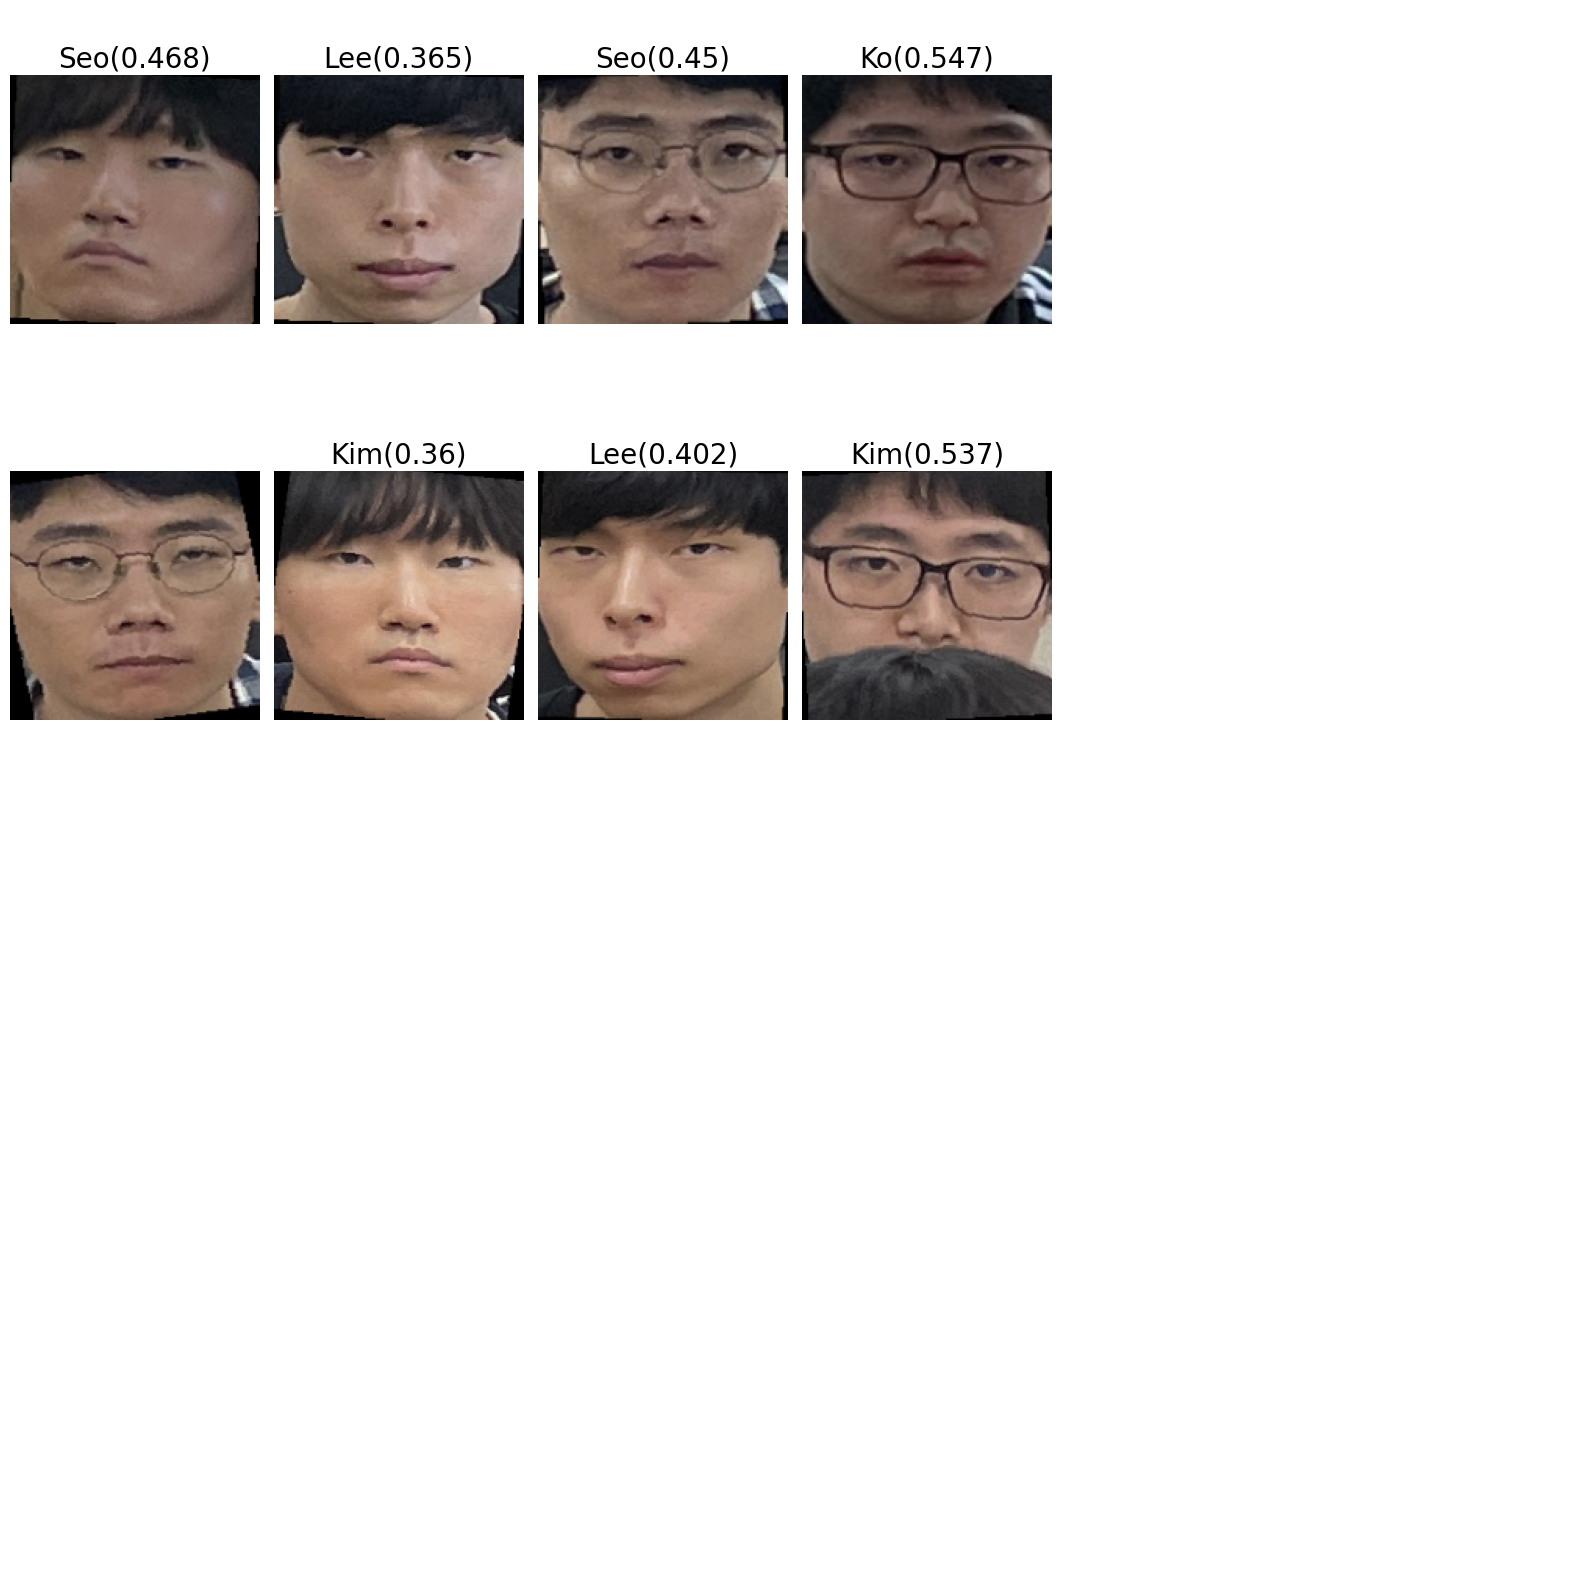

In [192]:
fig, axs = plt.subplots(4, 6, figsize=(16, 16))

for i, face in enumerate(var_faces):
    face = face.astype(np.float32)
    face = (face * 255).astype(np.uint8)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    title=pred[i]+'('+str(round(np.max(pred_proba[i]),3))+')'
    axs[i//4, i%4].imshow(face)
    axs[i//5, i%4].set_title(title, fontsize=20)
    
for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()

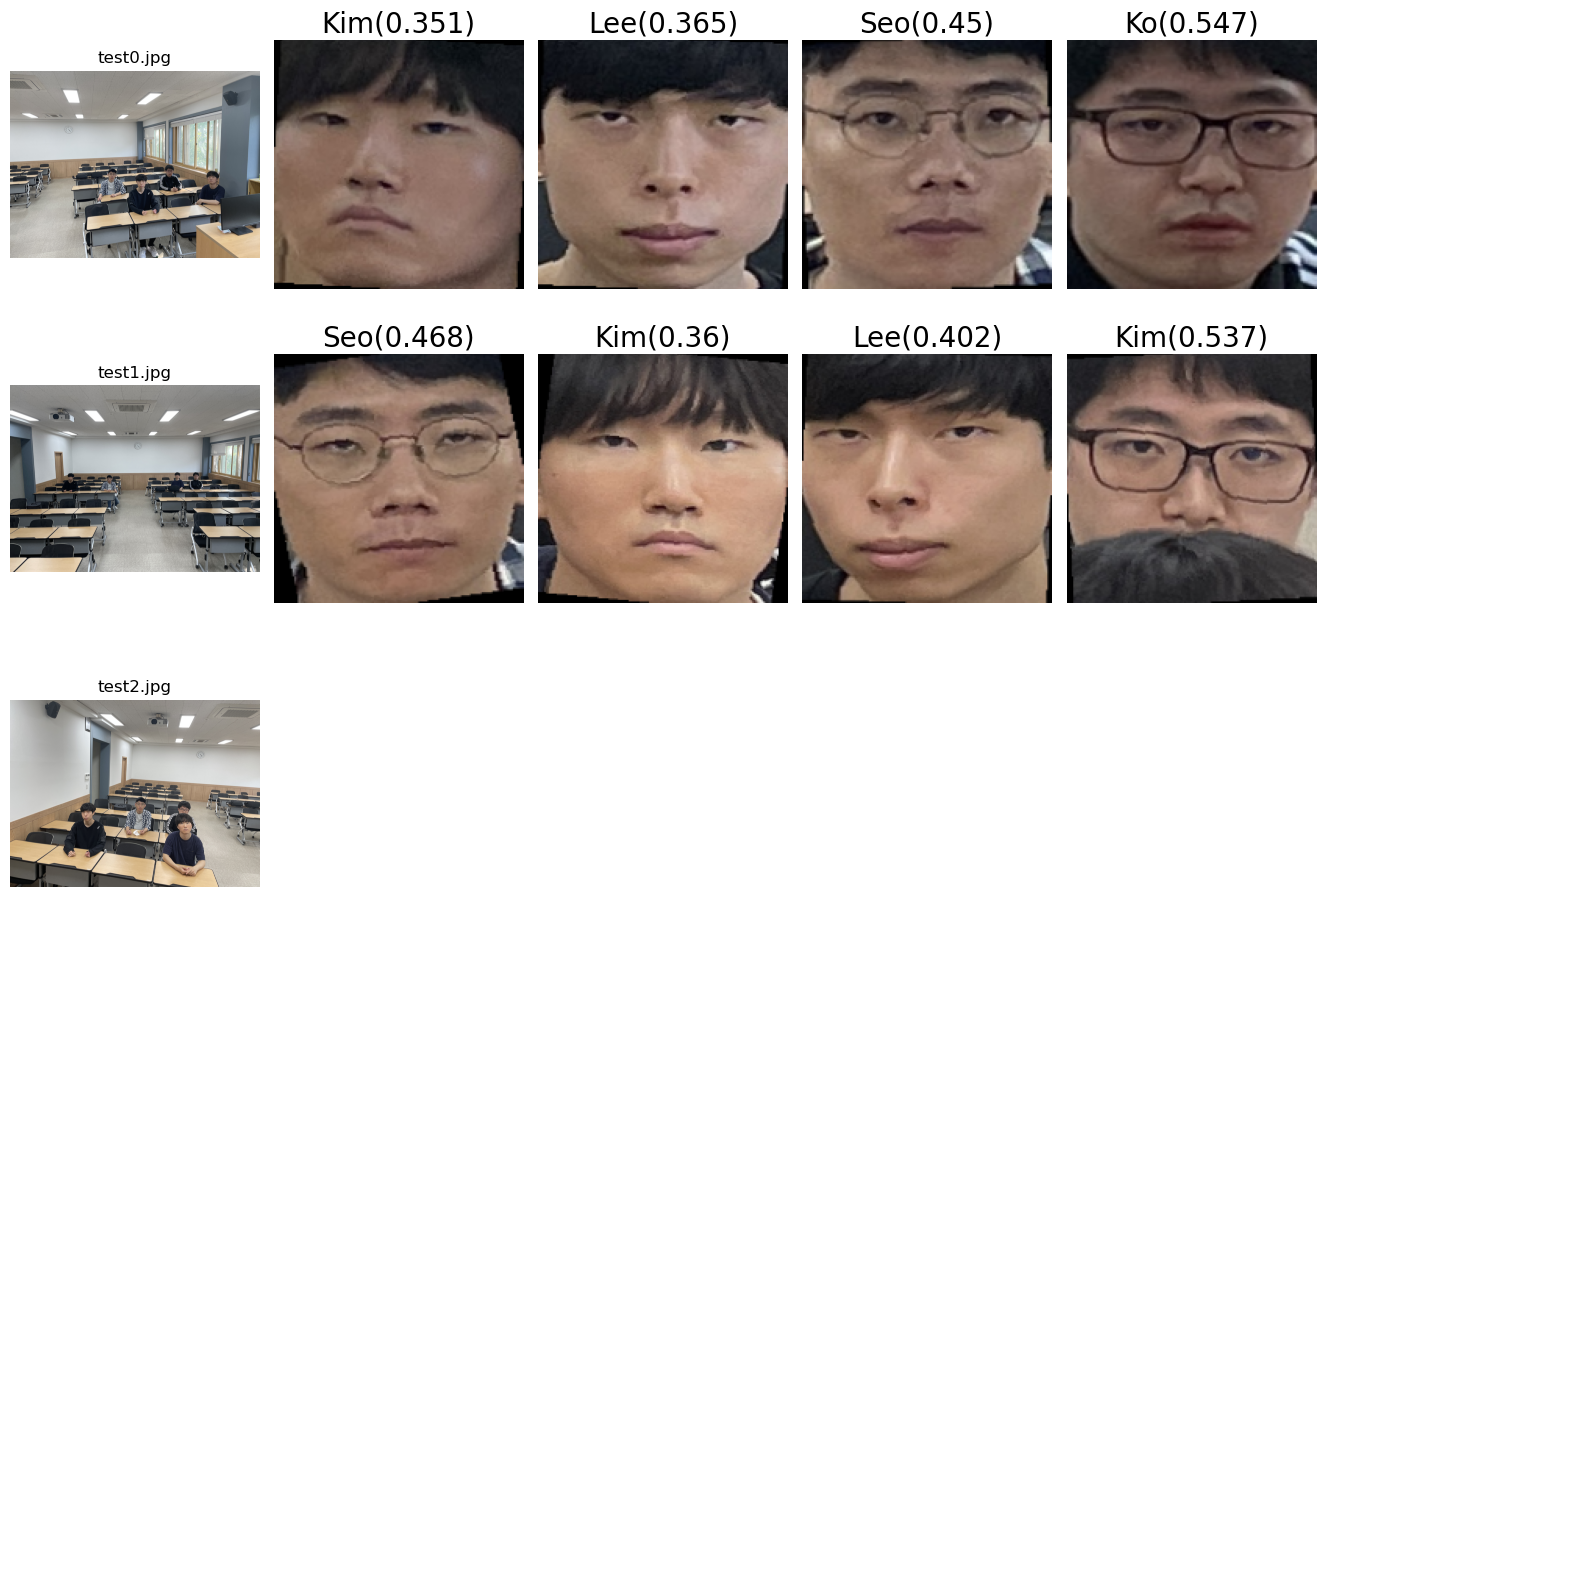

In [190]:
fig, axs = plt.subplots(5, 6, figsize=(16, 16))

for i in range(pred.size//4+1):
    img = mpimg.imread(image_dir_basepath+"Test/" + imgName.format(i))
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(imgName.format(i))

for i, face in enumerate(var_faces):
    face = face.astype(np.float32)
    face = (face * 255).astype(np.uint8)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    title=pred[i]+'('+str(round(np.max(pred_proba[i]),3))+')'
    axs[i//4, i%4+1].imshow(face)
    axs[i//4, i%4+1].set_title(title, fontsize=20)
    
for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()

In [199]:
present_stu = np.unique(pred)
print("출석한 학생은 " + str(present_stu.size) + "명 입니다.")
print(present_stu, end='')
print("가 출석했습니다.")

출석한 학생은 4명 입니다.
['Kim' 'Ko' 'Lee' 'Seo']가 출석했습니다.


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    axes[i].set_title(str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()


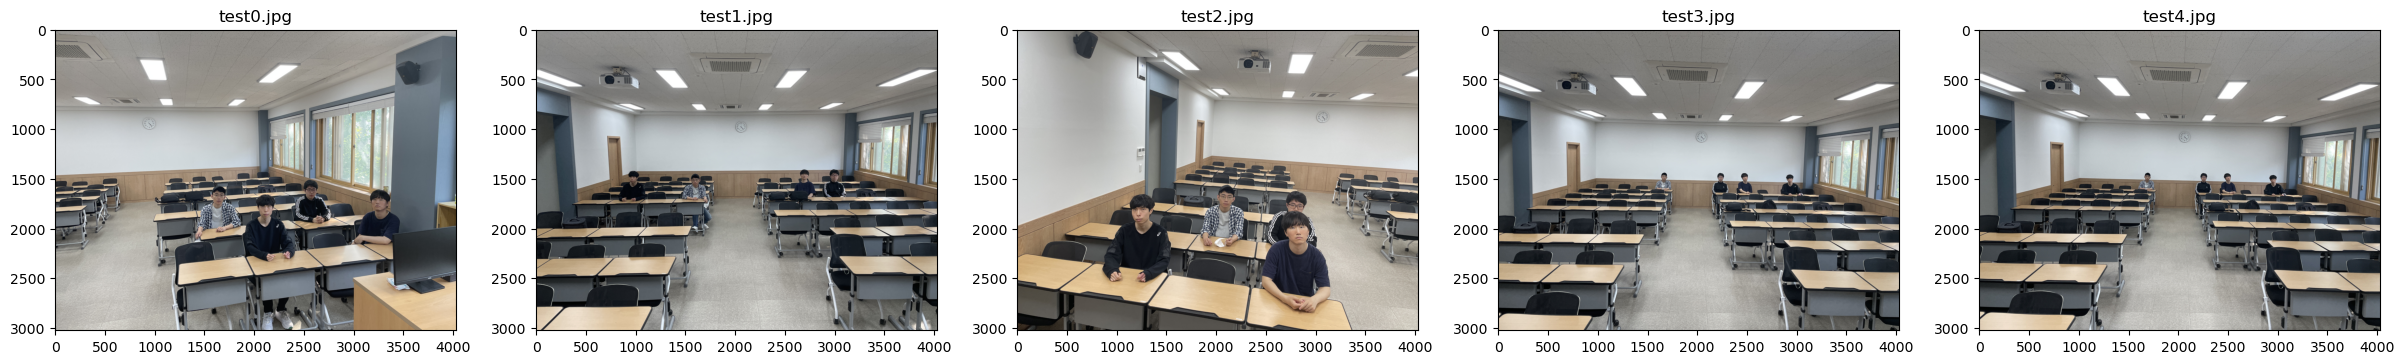

In [158]:
fig, axs = plt.subplots(1, 5, figsize=(16, 16))

for i in range(pred.size//4+1):
    img = mpimg.imread(image_dir_basepath+"Test/" + imgName.format(i))
    axs[i].imshow(img)
    axs[i].set_title(imgName.format(i))